In [1]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential 
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector 

In [2]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('acb.csv')

In [3]:
# Xử lý dữ liệu
prices = data['Price']

In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [5]:
scaled_prices

array([[0.13206988],
       [0.13068542],
       [0.13206988],
       ...,
       [0.62679829],
       [0.63605888],
       [0.64763461]])

In [6]:
#RATIO 73

In [7]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.9)
test_size = int(len(scaled_prices) * 0.1)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [8]:
test_data

array([[0.74950109],
       [0.75413138],
       [0.76802226],
       [0.75876167],
       [0.75644653],
       [0.75181623],
       [0.75876167],
       [0.76107682],
       [0.77033741],
       [0.58512564],
       [0.60364682],
       [0.60133167],
       [0.60364682],
       [0.60596197],
       [0.59438623],
       [0.59207108],
       [0.58744079],
       [0.59438623],
       [0.59670138],
       [0.59901653],
       [0.60364682],
       [0.59670138],
       [0.59670138],
       [0.59901653],
       [0.59670138],
       [0.60827711],
       [0.62448314],
       [0.622168  ],
       [0.62679829],
       [0.60827711],
       [0.61522256],
       [0.61522256],
       [0.61290741],
       [0.61059226],
       [0.59901653],
       [0.59901653],
       [0.61059226],
       [0.61290741],
       [0.60596197],
       [0.61290741],
       [0.61290741],
       [0.61290741],
       [0.61290741],
       [0.61290741],
       [0.61290741],
       [0.6175377 ],
       [0.61522256],
       [0.626

In [9]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [10]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [11]:
X_train.shape

(1306, 30, 1)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100

21/21 [==============================] - 2s 8ms/step - loss: 0.1638
Epoch 2/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0848
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0622
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 6/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 7/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 10/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 12/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 13/100
21/21 [================

In [15]:
data.index


RangeIndex(start=0, stop=1485, step=1)

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(data) + 1,len(data) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

4/4 [==============================] - 0s 3ms/step
[[1486]
 [1487]
 [1488]
 [1489]
 [1490]
 [1491]
 [1492]
 [1493]
 [1494]
 [1495]
 [1496]
 [1497]
 [1498]
 [1499]
 [1500]
 [1501]
 [1502]
 [1503]
 [1504]
 [1505]
 [1506]
 [1507]
 [1508]
 [1509]
 [1510]
 [1511]
 [1512]
 [1513]
 [1514]
 [1515]]
1/1 [==============================] - 0s 17ms/step
[21859.072 22032.275 22049.508 21963.482 22329.822 22482.926 22361.832
 22241.14  22391.63  22839.047 23137.729 22842.773 22409.71  22304.652
 22441.186 22248.035 21948.666 21705.992 21673.635 21795.254 21832.857
 21802.049 21975.662 22044.852 22098.045 22178.246 22238.852 22238.979
 22284.594 22211.432]


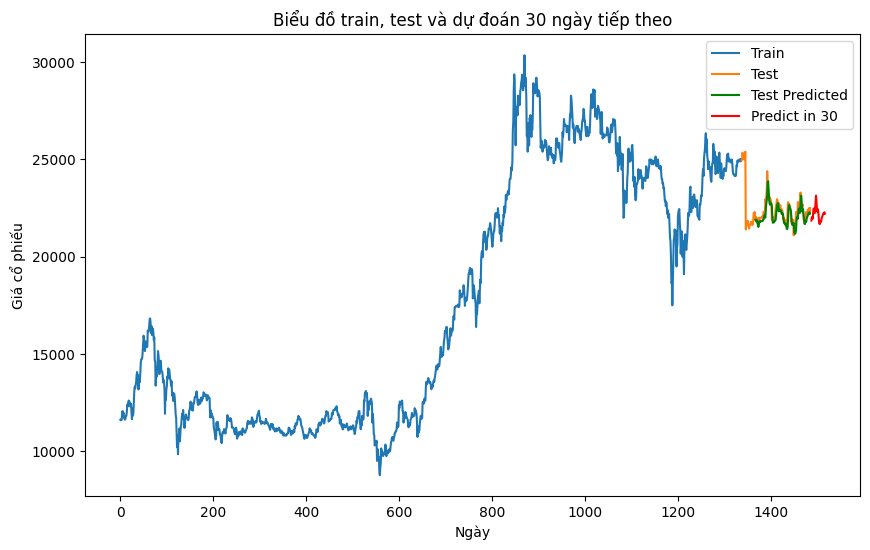

In [17]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict in 30')

plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Biểu đồ train, test và dự đoán 30 ngày tiếp theo')
plt.legend()
plt.show()

In [18]:
y_test_pred

array([[21903.69 ],
       [21813.752],
       [21838.205],
       [21858.701],
       [21807.465],
       [21635.766],
       [21526.582],
       [21653.846],
       [21815.506],
       [21781.537],
       [21783.146],
       [21820.826],
       [21844.883],
       [21837.227],
       [21833.262],
       [21831.879],
       [21888.94 ],
       [21903.887],
       [22032.54 ],
       [22126.54 ],
       [22066.787],
       [22008.494],
       [22435.365],
       [22728.809],
       [22898.166],
       [23130.643],
       [23828.84 ],
       [23883.008],
       [23456.838],
       [23046.385],
       [22777.4  ],
       [22677.95 ],
       [22769.98 ],
       [22751.148],
       [22710.107],
       [22586.717],
       [22059.941],
       [21747.627],
       [21761.785],
       [21758.574],
       [21806.3  ],
       [21811.684],
       [21855.059],
       [21877.559],
       [22117.51 ],
       [22369.086],
       [22557.643],
       [22716.8  ],
       [22765.096],
       [22656.87 ],


In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted, squared=False)




4/4 [==============================] - 0s 3ms/step


In [20]:
y_test1

array([[22050.],
       [22050.],
       [22000.],
       [21950.],
       [21700.],
       [21700.],
       [21950.],
       [22000.],
       [21850.],
       [22000.],
       [22000.],
       [22000.],
       [22000.],
       [22000.],
       [22000.],
       [22100.],
       [22050.],
       [22300.],
       [22300.],
       [22150.],
       [22200.],
       [22950.],
       [22850.],
       [23100.],
       [23450.],
       [24400.],
       [23750.],
       [23400.],
       [23200.],
       [22900.],
       [22900.],
       [23050.],
       [22850.],
       [22900.],
       [22700.],
       [21900.],
       [22000.],
       [22050.],
       [21850.],
       [22050.],
       [21950.],
       [22050.],
       [22050.],
       [22450.],
       [22600.],
       [22750.],
       [22950.],
       [22900.],
       [22750.],
       [22350.],
       [22750.],
       [22550.],
       [22450.],
       [22650.],
       [22450.],
       [22300.],
       [22450.],
       [22400.],
       [22300.

In [21]:
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')


---------TEST----------
MAPE: 1.169
MAE: 262.63
RMSE: 344.275
MSLE: 0.015
-------------------
